In [1]:
import torch 
from torch.nn import Module
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# df = pd.read_csv('C:/Users/louis/github_vs/archive/Submission.csv') Idk what this dataset is used for?
df = pd.read_csv('archive/fer2013/fer2013/fer2013.csv')

# some data formatting, returning the data in a tuple(img,label) form
def get_data(df, str):
    data = df[df["Usage"]==str]
    data_y = data['emotion'].reset_index(drop=True)
    # formatting form string to array of floats, of values in an [0,1] range, in an [1,48,48] shape
    data_x = data['pixels'].apply( lambda x : (np.array(x.split(" ")).astype(np.uint8)).reshape(-1,48,48))
    data_xy = [(x,y) for x,y in zip(data_y,data_x)]
    return data_xy


# supposedly a class that should speed up the training process (see https://discuss.pytorch.org/t/enumerate-dataloader-slow/87778/4)
class MultiEpochsDataLoader(torch.utils.data.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._DataLoader__initialized = False
        self.batch_sampler = _RepeatSampler(self.batch_sampler)
        self._DataLoader__initialized = True
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)


class _RepeatSampler(object):
    """ Sampler that repeats forever.
    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)


# loading the data in batches
batch_size = 512
trainloader = MultiEpochsDataLoader(get_data(df, "Training"), shuffle=True, batch_size=batch_size) # 28709 data instances
valloader = MultiEpochsDataLoader(get_data(df, "PublicTest"), shuffle=False, batch_size=batch_size) # 3589 data instances
testloader = MultiEpochsDataLoader(get_data(df, "PrivateTest"), shuffle=False, batch_size=batch_size) # 3589 data instances

# original class names, added manually, must be checked
class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

In [3]:
print(testloader.sampler.data_source[0][1].shape)

(1, 48, 48)


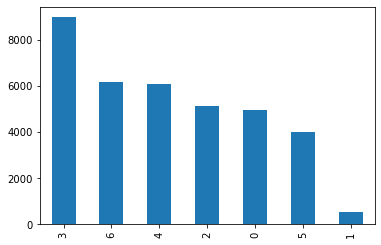

In [4]:
# checking for dataset imbalances
df['emotion'].value_counts().plot(kind = "bar");
# -> we must pay attention to class 1 (disgust)

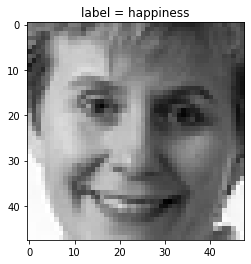

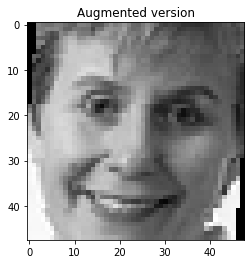

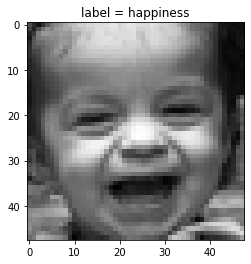

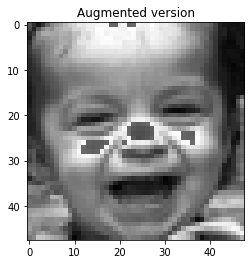

In [5]:
# showing some images, with their true labels
it = iter(trainloader)
out = next(it)
labels = out[0]
imgs= out[1]
for i in range(2):
    plt.figure()
    plt.imshow(imgs[i][0],cmap='gray')
    plt.title(f'label = {class_names[labels[i]]}')
    # displaying transformed version of the image
    augmenter = torchvision.transforms.RandAugment() # randomly applies 2 transformation to the image
    img_aug = augmenter(imgs)
    plt.figure()
    augmented = np.moveaxis(img_aug[i].numpy(),0,-1)
    plt.imshow(augmented, cmap='gray')
    plt.title('Augmented version')

In [6]:
# Augmentation techniques
# - rotation
# - vertical/horizontal flip
# - translation !keep the same img size

torch.manual_seed(17)
random_transform = torchvision.transforms.RandAugment() # randomly applies 2 transformation to the image

image_transformer = torchvision.transforms.Compose([
        torchvision.transforms.RandomApply(transforms=[random_transform], p=0.1),
        torchvision.transforms.Lambda(lambda t: t/255)  # Scale pixel values to 0-1
    ])

In [7]:
out_size = len(class_names);
scaler = 4 #scaling the number of channels from one con2d layer to another eg layer with SCALER channels -> layer with SCALER*2 channels
 
def update_size(input_size, filter, strides):
    return  input_size - int(np.floor((filter-2)/strides+1)) #formula can be found on https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

# building a customisable CNN sequential model
def build_model(order, filter_size, stride_size, pool_size, dropout_rate, scaler=scaler):
    
    input_size = 48 #keeping track of the different layer transformation on the size of the image
    layers = []
    
    # first layers
    layers.append(nn.Conv2d(in_channels=1, out_channels=scaler, kernel_size=filter_size, stride=stride_size))
    input_size = update_size(input_size, filter_size, stride_size)

    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=pool_size,stride=stride_size))
    input_size = update_size(input_size, pool_size, stride_size)
    
    # CNN stacked layers, order controls the number of layers added
    for i in range(1,order,2):
        layers.append(nn.Conv2d(scaler*i,scaler*(i+1), kernel_size = filter_size, stride=stride_size))
        input_size = update_size(input_size, filter_size, stride_size)
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(scaler*(i+1),scaler*(i+2), kernel_size = filter_size, stride=stride_size))
        input_size = update_size(input_size, filter_size, stride_size)
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=pool_size,stride=stride_size))
        input_size = update_size(input_size, pool_size, stride_size)

    # top classifier
    layers.append(nn.Flatten())
    layers.append(nn.Linear(input_size*input_size*scaler*(i+2), 32)) # 32 is an arbitrary number, must be greater than out_size
    # layers.append(nn.Dropout(p=dropout_rate)) # adding some randomness in the weights
    layers.append(nn.ReLU())
    # layers.append(nn.Flatten())
    layers.append(nn.Linear(32, out_size))     
    layers.append(nn.Softmax()) # prediction layer; TODO: specify input dimension for the softmax layer
    
    return  nn.Sequential(*layers)
# -----------------------------------------------
    
model = build_model(order=2, filter_size=3, stride_size=1, pool_size=10, dropout_rate=0.)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# training the model
for epoch in range(1,10):
    running_loss = 0
    for batch in trainloader: #iterating over the batches
        inputs = image_transformer(batch[1])
        labels = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'epoch {epoch} loss: {running_loss}')

# 1min/epoch, it is quite slow...

/Users/thomasbahne/Programmieren/miniforge3/envs/CVpy39/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch 1 loss: 108.09010410308838
epoch 2 loss: 107.69065344333649
epoch 3 loss: 106.81086659431458
epoch 4 loss: 106.28916823863983
epoch 5 loss: 105.92247986793518
epoch 6 loss: 105.20752716064453
epoch 7 loss: 105.1321450471878
epoch 8 loss: 104.9523434638977
epoch 9 loss: 104.76383781433105


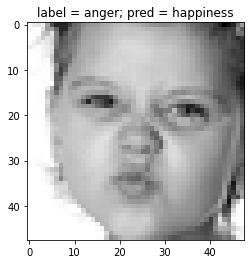

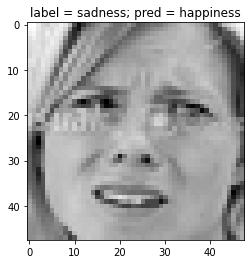

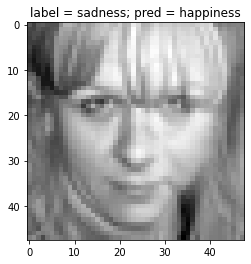

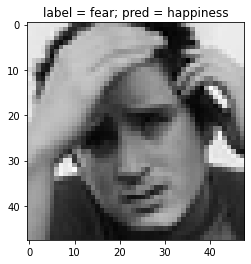

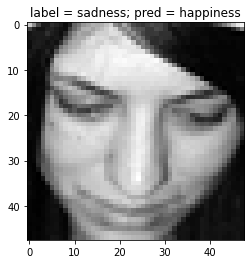

In [13]:
# printing some images with their predictions
it = iter(testloader)
out = next(it)
labels = out[0]
imgs= out[1]
preds = model(imgs.float()).argmax(dim=1).numpy()

for i in range(5):
    img = imgs[i][0]
    plt.figure()
    plt.imshow(img,cmap='gray')
    plt.title("label = "+class_names[labels[i]]+"; pred = "+class_names[preds[0]])
    
# the model is labelling everything with the majority class: happiness

In [9]:
# TODO implement parameter tuning experiments: scaler - pool_size - filter_size - stride_size - order - dropout_rate - dilation? 

In [10]:
# TODO Choose the best model

In [11]:
# TODO Visualise the learned filters
# Display the relevant activations for different emotions

In [12]:
# TODO test model on real life video, assess its quality